# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Felicia Pangestu
- Email: feliciapangestu.fp@gmail.com 
- Id Dicoding: feliciaa

## Persiapan

### Menyiapkan library yang dibutuhkan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import joblib 
import streamlit as st 

In [2]:
# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

### Menyiapkan data yang akan digunakan

In [ ]:
# Load the dataset
try:
    df = pd.read_csv('data.csv', delimiter=';')
    print("Data loaded successfully!")
    print("Shape of the dataset:", df.shape)
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please ensure the file is in the correct directory.")
    df = None 

Data loaded successfully!
Shape of the dataset: (4424, 37)


## Data Understanding


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                    

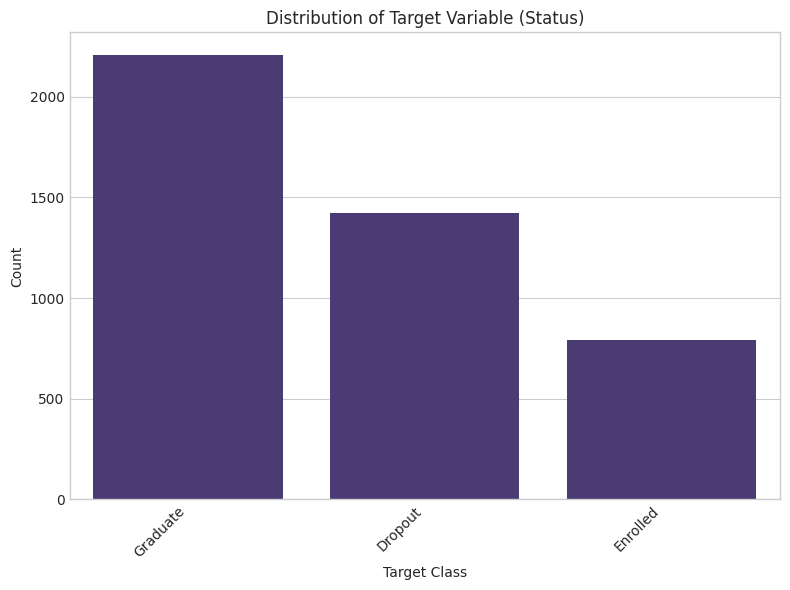

Unique values in 'Status': ['Dropout' 'Graduate' 'Enrolled']
Using target mapping: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


In [ ]:
if df is not None:
    # Display basic information about the dataset
    print("\nDataset Information:")
    df.info()

    # Display descriptive statistics
    print("\nDescriptive Statistics:")
    print(df.describe(include='all'))

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # --- Dynamically identify the target variable (assuming it's the last column) ---
    if not df.empty:
        TARGET_COLUMN_NAME = df.columns[-1]
        print(f"\nAssuming the target variable is the last column: '{TARGET_COLUMN_NAME}'")

        print("\nTarget variable distribution:")
        target_counts = df[TARGET_COLUMN_NAME].value_counts()
        print(target_counts)

        plt.figure(figsize=(8, 6))
        sns.countplot(x=TARGET_COLUMN_NAME, data=df, order = target_counts.index) # Ensure order for clarity
        plt.title(f'Distribution of Target Variable ({TARGET_COLUMN_NAME})')
        plt.xlabel('Target Class')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right') 
        plt.tight_layout() 
        plt.show()

        unique_target_values = df[TARGET_COLUMN_NAME].unique()
        print(f"Unique values in '{TARGET_COLUMN_NAME}': {unique_target_values}")

        if all(isinstance(val, str) for val in unique_target_values):
            sorted_unique_values = sorted(list(unique_target_values)) # Sort alphabetically for some consistency
            target_mapping = {val: i for i, val in enumerate(sorted_unique_values)}
            preferred_order = ['Dropout', 'Enrolled', 'Graduate']
            actual_values_in_data = df[TARGET_COLUMN_NAME].unique()
            
            current_target_mapping = {}
            idx = 0
            for item in preferred_order:
                if item in actual_values_in_data:
                    current_target_mapping[item] = idx
                    idx += 1
            for item in actual_values_in_data:
                if item not in current_target_mapping:
                    current_target_mapping[item] = idx
                    idx +=1

            if len(current_target_mapping) != len(actual_values_in_data):
                 print(f"Warning: Automatic target mapping might be incomplete or incorrect. Please verify.")
                 print(f"Values found: {actual_values_in_data}. Mapping attempted: {current_target_mapping}")
                 if not current_target_mapping or len(current_target_mapping) < len(actual_values_in_data):
                     print("Reverting to simple enumeration for target mapping.")
                     current_target_mapping = {val: i for i, val in enumerate(df[TARGET_COLUMN_NAME].astype('category').cat.categories)}


            target_mapping = current_target_mapping
            print(f"Using target mapping: {target_mapping}")

        elif all(isinstance(val, (int, np.integer)) for val in unique_target_values):
            target_mapping = {val: val for val in sorted(list(unique_target_values))}
            print(f"Target variable is already numeric. Using identity mapping: {target_mapping}")
        else:
            print("Target variable contains mixed types or non-string/non-integer types that are not automatically mapped. Manual mapping required.")
            target_mapping = None 

    else:
        print("DataFrame is empty. Cannot perform Data Understanding.")
        TARGET_COLUMN_NAME = None
        target_mapping = None

else:
    print("Dataset not loaded. Skipping Data Understanding steps.")
    TARGET_COLUMN_NAME = None
    target_mapping = None

## Data Preparation / Preprocessing

In [ ]:
if 'df' in locals() and df is not None and \
   'TARGET_COLUMN_NAME' in locals() and TARGET_COLUMN_NAME and \
   'target_mapping' in locals() and target_mapping is not None:

    print(f"\n--- 1. Target Encoding and Feature/Target Separation ---")
    # 1. Encoding Variabel Target
    try:
        df['Target_Encoded'] = df[TARGET_COLUMN_NAME].map(target_mapping)
        if df['Target_Encoded'].isnull().any():
            print(f"Warning: NaN values found in 'Target_Encoded' after mapping. This can occur if not all unique values in '{TARGET_COLUMN_NAME}' were present in 'target_mapping'.")
            print(f"  Unique values in '{TARGET_COLUMN_NAME}' before mapping: {df[TARGET_COLUMN_NAME].unique()}")
            print(f"  Target_mapping used: {target_mapping}")
            print(f"  Problematic rows (where Target_Encoded is NaN) - First 5:")
            print(df[df['Target_Encoded'].isnull()][[TARGET_COLUMN_NAME, 'Target_Encoded']].head())
    except Exception as e:
        print(f"Error during target variable mapping: {e}. 'Target_Encoded' might not be created correctly.")
        if 'Target_Encoded' not in df.columns:
             df['Target_Encoded'] = pd.Series(dtype='float') # Atau tipe data lain yang sesuai

    # 2. Pemisahan Fitur dan Target
    if 'Target_Encoded' in df.columns:
        X = df.drop([TARGET_COLUMN_NAME, 'Target_Encoded'], axis=1, errors='ignore')
        
        if not df['Target_Encoded'].isnull().all(): # Cek apakah tidak semuanya NaN
            y = df['Target_Encoded']
            if y.isnull().any():
                print("CRITICAL WARNING: NaNs are present in the target variable 'y' AFTER mapping and before splitting.")
                print(f"  Number of NaNs in y: {y.isnull().sum()}")
                print("  This will likely cause errors in train_test_split stratify or model training.")
                print("  Consider handling these NaNs (e.g., by dropping rows in both X and y) before proceeding.")
                valid_indices = y.dropna().index
                y = y.loc[valid_indices]
                X = X.loc[valid_indices]
            print(f"Features (X) and Target (y) separated. Shape of X: {X.shape}, Shape of y: {y.shape}")
        else:
            print(f"Error: 'Target_Encoded' column is all NaN or could not be properly created. Cannot define 'y'.")
            X = None 
            y = None
    else:
        print(f"Error: 'Target_Encoded' column not found in DataFrame. Cannot proceed with feature/target separation.")
        X = None
        y = None
else:
    print("DataFrame (df), TARGET_COLUMN_NAME, or target_mapping not available. Skipping Target Encoding and Feature/Target Separation.")
    X = None
    y = None


--- 1. Target Encoding and Feature/Target Separation ---
Features (X) and Target (y) separated. Shape of X: (4424, 36), Shape of y: (4424,)


In [ ]:
if X is not None and y is not None:
    print(f"\n--- 2. Feature Type Identification and Data Splitting ---")
    categorical_features = X.select_dtypes(include=['object']).columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

    print(f"Identified Categorical features: {list(categorical_features)}")
    print(f"Identified Numerical features: {list(numerical_features)}")

    if y.isnull().any():
        print(f"CRITICAL WARNING: 'y' still contains {y.isnull().sum()} NaN values before train_test_split.")
        print("  Stratify will likely fail. Please ensure NaNs in 'y' (and corresponding rows in 'X') are handled in the previous step.")
    else:
        # 3. Pembagian Data
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
            print(f"Data successfully split into training and testing sets.")
            print(f"  Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")
            print(f"  Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}")
            # Verifikasi distribusi kelas di y_train dan y_test jika perlu
            # print(f"  y_train distribution:\n{y_train.value_counts(normalize=True)}")
            # print(f"  y_test distribution:\n{y_test.value_counts(normalize=True)}")
        except Exception as e:
            print(f"Error during train_test_split: {e}")
            print("  This might be due to NaNs in 'y' or issues with stratify if classes are too few after NaN handling.")
            X_train, X_test, y_train, y_test = None, None, None, None # Invalidate

else:
    print("Features (X) or Target (y) not available from the previous step. Skipping Feature Identification and Data Splitting.")
    # Inisialisasi agar sel berikutnya tidak error
    X_train, X_test, y_train, y_test = None, None, None, None
    numerical_features, categorical_features = pd.Index([]), pd.Index([])


--- 2. Feature Type Identification and Data Splitting ---
Identified Categorical features: []
Identified Numerical features: ['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime_evening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd

In [8]:
# Pastikan numerical_features dan categorical_features sudah terdefinisi
if 'numerical_features' in locals() and 'categorical_features' in locals():
    print(f"\n--- 3. Defining Preprocessing Pipelines ---")
    # 4. Pipeline untuk Fitur Numerik: Imputasi median dan Scaling
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    print("Numerical pipeline defined.")

    # Pipeline untuk Fitur Kategorikal: Imputasi modus dan One-Hot Encoding
    # Hanya buat pipeline ini jika ada fitur kategorikal
    if not categorical_features.empty:
        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False untuk array NumPy
        ])
        print("Categorical pipeline defined.")
    else:
        categorical_pipeline = None # atau 'drop' jika tidak ada fitur kategorikal
        print("No categorical features identified to build a categorical pipeline.")

    # ColumnTransformer untuk menerapkan transformasi yang berbeda ke kolom yang berbeda
    # Hanya sertakan 'categorical' transformer jika categorical_pipeline terdefinisi
    transformers_list = [('numerical', numerical_pipeline, numerical_features)]
    if categorical_pipeline is not None and not categorical_features.empty:
        transformers_list.append(('categorical', categorical_pipeline, categorical_features))
    
    if not transformers_list:
        print("Error: No features available to build ColumnTransformer (numerical_features might be empty too).")
        preprocessor = None
    else:
        preprocessor = ColumnTransformer(transformers_list, remainder='passthrough')
        # 'passthrough' akan menjaga kolom lain yang tidak disebutkan (jika ada dan diinginkan)
        # atau gunakan remainder='drop' untuk membuang kolom lain
        print("ColumnTransformer (preprocessor) defined.")
        # print(preprocessor) # Bisa di-uncomment untuk melihat detail preprocessor

else:
    print("Numerical or categorical feature lists not available. Skipping Preprocessing Pipeline Definition.")
    preprocessor = None


--- 3. Defining Preprocessing Pipelines ---
Numerical pipeline defined.
No categorical features identified to build a categorical pipeline.
ColumnTransformer (preprocessor) defined.


In [9]:
if 'X_train' in locals() and X_train is not None and \
   'X_test' in locals() and X_test is not None and \
   'preprocessor' in locals() and preprocessor is not None:

    print(f"\n--- 4. Applying Preprocessing Pipeline and Verifying Processed Features ---")
    try:
        # Terapkan pipeline pra-pemrosesan pada data training dan testing
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        print(f"Preprocessing applied successfully.")
        print(f"  Shape of X_train_processed: {X_train_processed.shape}")
        print(f"  Shape of X_test_processed: {X_test_processed.shape}")

        # Mencoba mendapatkan nama fitur setelah One-Hot Encoding (OHE)
        processed_feature_names = None # Inisialisasi
        try:
            # Mengambil nama fitur dari pipeline numerik (sama dengan input)
            num_feature_names = numerical_features.tolist()
            
            ohe_feature_names = []
            # Mengambil nama fitur dari pipeline kategorikal setelah OHE
            # Cek apakah 'categorical' transformer ada di preprocessor
            if 'categorical' in preprocessor.named_transformers_ and preprocessor.named_transformers_['categorical'] is not None:
                # Cek apakah langkah 'onehot' ada di dalam pipeline kategorikal
                cat_pipeline_steps = preprocessor.named_transformers_['categorical'].steps
                onehot_step = next((step for name, step in cat_pipeline_steps if name == 'onehot'), None)

                if onehot_step and hasattr(onehot_step, 'get_feature_names_out') and not categorical_features.empty:
                    ohe_feature_names = onehot_step.get_feature_names_out(categorical_features).tolist()
            
            # Mengambil nama fitur yang di-'passthrough' (jika ada)
            passthrough_feature_names = []
            if preprocessor.remainder == 'passthrough':
                # Ini memerlukan cara untuk mengetahui indeks kolom asli yang di-passthrough
                # Cara sederhana: jika X_train adalah DataFrame pandas
                num_transformed_cols = len(num_feature_names) + len(ohe_feature_names)
                if X_train_processed.shape[1] > num_transformed_cols:
                    # Ini mengasumsikan kolom passthrough adalah yang terakhir setelah transformasi
                    # dan kita tahu berapa banyak kolom asli yang di-passthrough
                    # Cara yang lebih baik adalah jika preprocessor.get_feature_names_out() bekerja secara keseluruhan
                    # Untuk sekarang, kita bisa coba cara ini jika X_train adalah DataFrame:
                    # passthrough_indices = [i for i, t in enumerate(preprocessor.transformers_) if t[0] == 'remainder_'] # Tidak standar
                    # Untuk `remainder='passthrough'`, fitur-fitur ini akan ditambahkan di akhir.
                    # Jika ada fitur yang tidak termasuk numerical atau categorical features, itulah yang di-passthrough.
                    # Kolom X_train yang tidak ada di numerical_features maupun categorical_features
                    original_cols = X_train.columns
                    processed_cols_in_transformer = list(numerical_features) + list(categorical_features)
                    passthrough_original_names = [col for col in original_cols if col not in processed_cols_in_transformer]
                    if len(passthrough_original_names) == (X_train_processed.shape[1] - num_transformed_cols):
                         passthrough_feature_names = passthrough_original_names
                    else:
                         print("  Warning: Could not reliably determine passthrough feature names by simple column difference.")


            processed_feature_names = num_feature_names + ohe_feature_names + passthrough_feature_names
            
            if len(processed_feature_names) != X_train_processed.shape[1]:
                print(f"  Warning: Mismatch in length of generated feature names ({len(processed_feature_names)}) and number of columns in processed data ({X_train_processed.shape[1]}).")
                print("    Feature names might be incomplete or incorrect. Trying preprocessor.get_feature_names_out() if available.")
                if hasattr(preprocessor, 'get_feature_names_out'):
                    try:
                        processed_feature_names = preprocessor.get_feature_names_out() # Ini cara yang lebih modern
                        if len(processed_feature_names) == X_train_processed.shape[1]:
                             print("    Successfully used preprocessor.get_feature_names_out().")
                        else:
                             print("    preprocessor.get_feature_names_out() also resulted in a mismatch.")
                             processed_feature_names = None # Reset jika masih mismatch
                    except Exception as e_fn:
                        print(f"    Error calling preprocessor.get_feature_names_out(): {e_fn}")
                        processed_feature_names = None # Reset jika error
                else:
                    processed_feature_names = None # Reset jika tidak ada metode get_feature_names_out

            if processed_feature_names is not None:
                 print(f"  Successfully generated/retrieved {len(processed_feature_names)} processed feature names.")
            else:
                 print("  Could not reliably determine all processed feature names. Feature importance plots might lack names or fail.")

        except Exception as e:
            print(f"  Error occurred while trying to get processed feature names: {e}")
            processed_feature_names = None # Pastikan di-set None jika ada error

        print("Data preprocessing application complete.")

    except Exception as e:
        print(f"Error applying preprocessing pipeline: {e}")
        X_train_processed, X_test_processed, processed_feature_names = None, None, None # Invalidate
else:
    print("Training/testing data or preprocessor not available from previous steps. Skipping Preprocessing Application.")
    # Inisialisasi agar sel berikutnya tidak error
    X_train_processed, X_test_processed, processed_feature_names = None, None, None


--- 4. Applying Preprocessing Pipeline and Verifying Processed Features ---
Preprocessing applied successfully.
  Shape of X_train_processed: (3539, 36)
  Shape of X_test_processed: (885, 36)
  Successfully generated/retrieved 36 processed feature names.
Data preprocessing application complete.


## Modeling

In [ ]:
if 'X_train_processed' in locals() and 'y_train' in locals() and 'X_test_processed' in locals() and 'y_test' in locals() and target_mapping is not None:
    models = {
        "Logistic Regression": LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42, max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
    }

    results = {}
    best_model_name = None
    best_model = None
    best_accuracy = 0.0
    trained_models = {}

    print("\nStarting model training and evaluation...\n")

    for model_name, model_instance in models.items(): # renamed model to model_instance to avoid conflict
        print(f"--- Training {model_name} ---")
        model_instance.fit(X_train_processed, y_train)
        y_pred = model_instance.predict(X_test_processed)

        accuracy = accuracy_score(y_test, y_pred)

        inv_target_mapping = {v: k for k, v in target_mapping.items()}
        report_target_names = [inv_target_mapping[i] for i in sorted(inv_target_mapping.keys())]


        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0, labels=np.unique(y_pred)) # ensure labels match
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0, labels=np.unique(y_pred))
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0, labels=np.unique(y_pred))

        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Classification Report": classification_report(y_test, y_pred, target_names=report_target_names, zero_division=0, labels=sorted(target_mapping.values())),
            "Confusion Matrix": confusion_matrix(y_test, y_pred, labels=sorted(target_mapping.values()))
        }
        trained_models[model_name] = model_instance

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")
        print(f"F1-score (weighted): {f1:.4f}")
        print("-----------------------------\n")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = model_name
            best_model = model_instance

    print(f"\nBest performing model: {best_model_name} with Accuracy: {best_accuracy:.4f}")

    if best_model is not None:
        joblib.dump(best_model, 'best_model.pkl')
        joblib.dump(preprocessor, 'preprocessor.pkl')
        joblib.dump(target_mapping, 'target_mapping.pkl')
        joblib.dump(numerical_features.tolist(), 'numerical_features.pkl') # Save as list
        joblib.dump(categorical_features.tolist(), 'categorical_features.pkl') # Save as list
        joblib.dump(TARGET_COLUMN_NAME, 'target_column_name.pkl')
        print("\nBest model, preprocessor, target mapping, feature lists, and target column name saved successfully!")
    else:
        print("No best model was selected. Saving artifacts skipped.")

else:
    print("Required variables from Data Preparation are not available. Skipping Modeling.")


Starting model training and evaluation...

--- Training Logistic Regression ---
Accuracy: 0.7605
Precision (weighted): 0.7377
Recall (weighted): 0.7605
F1-score (weighted): 0.7377
-----------------------------

--- Training Decision Tree ---


/root/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6949
Precision (weighted): 0.7001
Recall (weighted): 0.6949
F1-score (weighted): 0.6974
-----------------------------

--- Training Random Forest ---
Accuracy: 0.7638
Precision (weighted): 0.7492
Recall (weighted): 0.7638
F1-score (weighted): 0.7493
-----------------------------


Best performing model: Random Forest with Accuracy: 0.7638

Best model, preprocessor, target mapping, feature lists, and target column name saved successfully!


## Evaluation

In [11]:
# Pastikan variabel 'results', 'best_model_name', dan 'target_mapping' sudah ada dari sel Modeling
if 'results' in locals() and 'target_mapping' in locals():
    print("\n--- Evaluation Results: Overall Model Performance ---")
    for model_name, metrics in results.items():
        print(f"\nModel: {model_name}")
        print(f"  Accuracy: {metrics['Accuracy']:.4f}")
        print(f"  Precision (weighted): {metrics['Precision']:.4f}")
        print(f"  Recall (weighted): {metrics['Recall']:.4f}")
        print(f"  F1-score (weighted): {metrics['F1-score']:.4f}")
else:
    print("Modeling results or target_mapping not available. Skipping overall performance display.")


--- Evaluation Results: Overall Model Performance ---

Model: Logistic Regression
  Accuracy: 0.7605
  Precision (weighted): 0.7377
  Recall (weighted): 0.7605
  F1-score (weighted): 0.7377

Model: Decision Tree
  Accuracy: 0.6949
  Precision (weighted): 0.7001
  Recall (weighted): 0.6949
  F1-score (weighted): 0.6974

Model: Random Forest
  Accuracy: 0.7638
  Precision (weighted): 0.7492
  Recall (weighted): 0.7638
  F1-score (weighted): 0.7493



--- Detailed Report for Best Model: Random Forest ---

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.80      0.75      0.77       284
    Enrolled       0.56      0.35      0.43       159
    Graduate       0.78      0.92      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.76      0.75       885


Confusion Matrix:


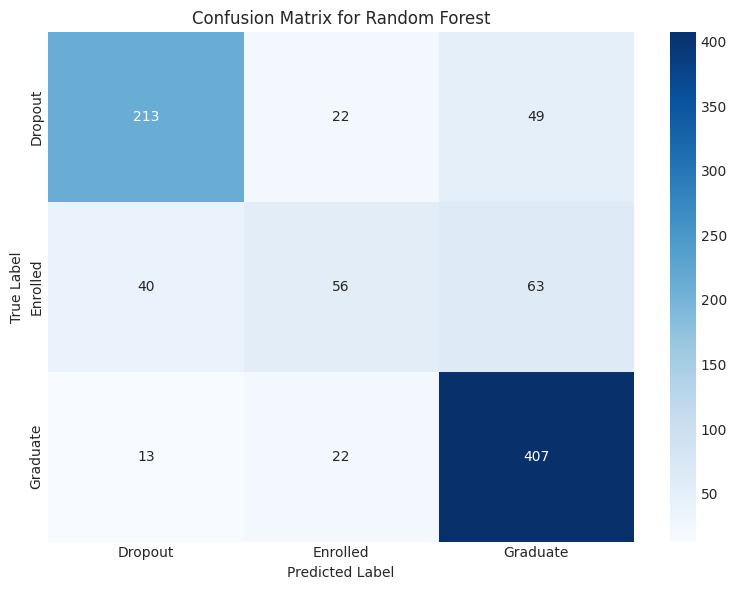

In [ ]:
if 'results' in locals() and 'best_model_name' in locals() and best_model_name is not None and 'target_mapping' in locals():
    if best_model_name in results:
        print(f"\n--- Detailed Report for Best Model: {best_model_name} ---")

        # --- Classification Report ---
        print("\nClassification Report:")
        if "Classification Report" in results[best_model_name]:
            print(results[best_model_name]["Classification Report"])
        else:
            print(f"Classification Report not found for {best_model_name}.")

        # --- Confusion Matrix ---
        print("\nConfusion Matrix:")
        if "Confusion Matrix" in results[best_model_name]:
            cm = results[best_model_name]["Confusion Matrix"]
            
            # Membuat label untuk sumbu confusion matrix
            inv_target_mapping = {v: k for k, v in target_mapping.items()}
            cm_display_labels = [inv_target_mapping[i] for i in sorted(inv_target_mapping.keys())]

            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=cm_display_labels,
                        yticklabels=cm_display_labels)
            plt.title(f'Confusion Matrix for {best_model_name}')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Confusion Matrix not found for {best_model_name}.")
    else:
        print(f"Results for the best model ({best_model_name}) not found.")
else:
    print("Modeling results, best_model_name, or target_mapping not available. Skipping detailed report for the best model.")


--- Feature Importance Analysis for Random Forest ---

Feature importances saved to feature_importances.csv successfully.


/tmp/ipykernel_116537/3691095133.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_15_features, palette='viridis')


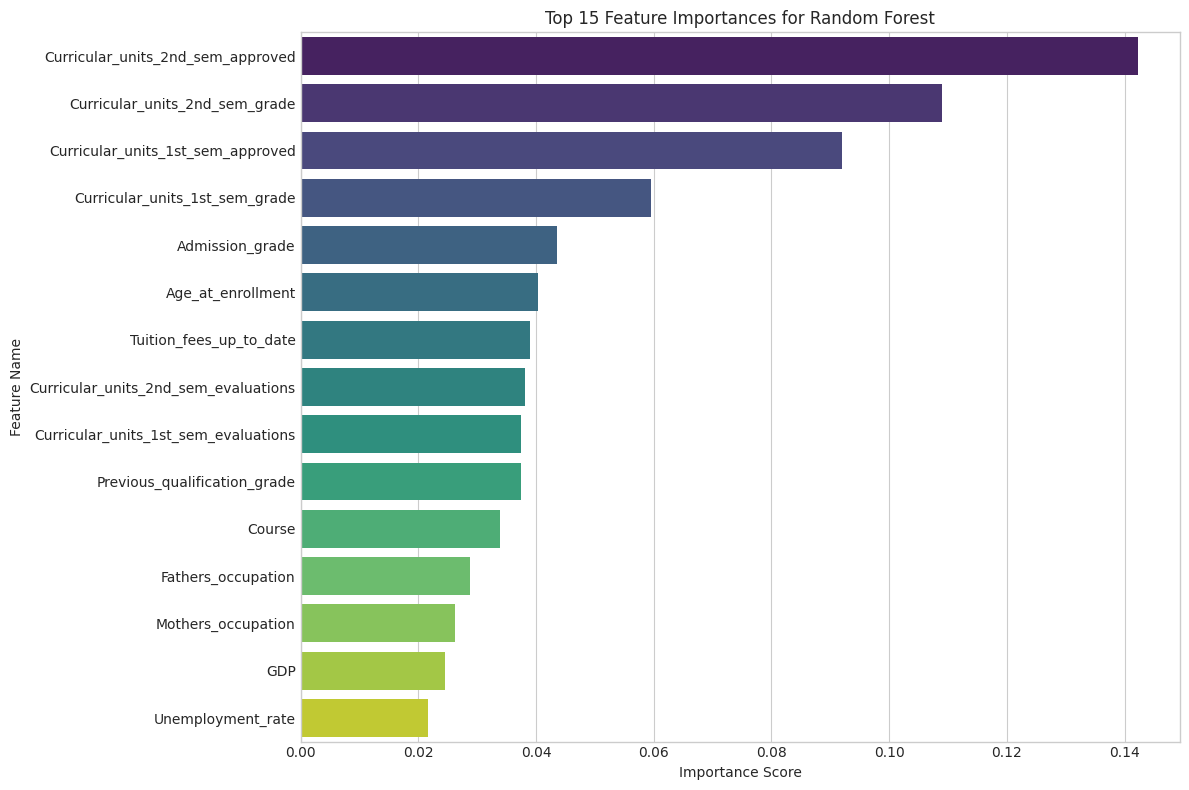

In [ ]:
if ('best_model_name' in locals() and best_model_name is not None and
    'best_model' in locals() and best_model is not None and
    'X_train_processed' in locals() and X_train_processed is not None and
    'preprocessor' in locals() and preprocessor is not None):

    print(f"\n--- Feature Importance Analysis for {best_model_name} ---")

    if best_model_name in ["Random Forest", "Decision Tree"] and hasattr(best_model, 'feature_importances_'):
        current_processed_feature_names = None
        if 'processed_feature_names' in locals() and processed_feature_names is not None:
            current_processed_feature_names = processed_feature_names
        elif hasattr(preprocessor, 'get_feature_names_out'):
            try:
                current_processed_feature_names = preprocessor.get_feature_names_out()
                print("Successfully retrieved feature names using preprocessor.get_feature_names_out()")
            except Exception as e:
                print(f"Could not get feature names using preprocessor.get_feature_names_out(): {e}")
        
        if current_processed_feature_names is not None and len(current_processed_feature_names) == X_train_processed.shape[1]:
            importances = best_model.feature_importances_
            feature_importance_df = pd.DataFrame({'feature': current_processed_feature_names, 'importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

            # --- Simpan Feature Importance ke CSV ---
            try:
                feature_importance_df.to_csv('feature_importances.csv', index=False)
                print("\nFeature importances saved to feature_importances.csv successfully.")
            except Exception as e:
                print(f"\nError saving feature importances to CSV: {e}")

            # --- Plot Top 15 Feature Importances ---
            top_15_features = feature_importance_df.head(15)
            plt.figure(figsize=(12, 8))
            sns.barplot(x='importance', y='feature', data=top_15_features, palette='viridis')
            plt.title(f'Top 15 Feature Importances for {best_model_name}')
            plt.xlabel('Importance Score')
            plt.ylabel('Feature Name')
            plt.tight_layout()
            plt.show()
        else:
            print("\nCannot display or save feature importances due to issues with feature names:")
            if current_processed_feature_names is None:
                print("  - Processed feature names are not available.")
            else:
                print(f"  - Mismatch in dimensions: Model expects {len(best_model.feature_importances_)} features, "
                    f"but {len(current_processed_feature_names)} processed feature names were found.")
            print(f"Number of features in model according to feature_importances_: {len(best_model.feature_importances_)}")
            print(f"Shape of X_train_processed (columns): {X_train_processed.shape[1]}")
    elif best_model_name not in ["Random Forest", "Decision Tree"]:
        print(f"\nFeature importance analysis is typically available for tree-based models. "
            f"The best model '{best_model_name}' does not directly provide feature_importances_ in the same way.")
    else: # hasattr(best_model, 'feature_importances_') is False
         print(f"\nThe best model '{best_model_name}' does not have a 'feature_importances_' attribute.")
else:
    print("\nRequired variables for Feature Importance Analysis (e.g., best_model, X_train_processed, preprocessor) are not available. Skipping this step.")